# Imports

In [274]:
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import tensorflow_probability as tfp
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt

from sklearn.metrics import d2_tweedie_score

# Data

Load and prepare your dataset. Dataset should have at least 10k samples in it. Each dataset cannot be used by more than two students.

I took a large dataset of Android apps that provides insight into the types of feedback that users report.

Dataset: https://huggingface.co/datasets/app_reviews

In [275]:
from datasets import load_dataset

data = load_dataset('app_reviews', split='train')

In [3]:
data

Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 288065
})

# Backbone

Load pretrained model from Hugging Face (or some other model repository if it's more convenient). Model should be trained on Feature Extraction task.

I got the following model: https://huggingface.co/SamLowe/roberta-base-go_emotions

In [5]:
backbone = transformers.TFAutoModel.from_pretrained('SamLowe/roberta-base-go_emotions')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['classifier.out_proj.bias', 'classifier.dense.bias', 'roberta.embeddings.position_ids', 'classifier.dense.weight', 'classifier.out_proj.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
S

In [6]:
backbone.summary()

Model: "tf_roberta_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124645632 
 r)                                                              
                                                                 
Total params: 124645632 (475.49 MB)
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124645632 
 r)                                                              
                                                                 
Total params: 124645632 (475.49 MB)
Trainable params: 124645632 (475.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Load tokenizer to be used with the model

In [7]:
tokenizer = transformers.AutoTokenizer.from_pretrained('SamLowe/roberta-base-go_emotions')

# Feature extraction

Since we will not be training the backbone, extract features from your dataset.

Tokenize all your sequences. Truncate/pad the squences for convenience. If the sequences are too large to be stored in memory, lazily save them on disk.

Run the backbone on the sequences and save the extracted features. The extracted features should be a vector containing information about the whole text. If the features are too large to be stored in memory, lazily save them on disk.

In [8]:
tokenize_seq = []

for text in tqdm.tqdm(data['review']):
    tokenize_seq.append(tokenizer(text))

  0%|          | 0/288065 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (617 > 512). Running this sequence through the model will result in indexing errors


(array([2.84771e+05, 3.01800e+03, 2.00000e+02, 3.50000e+01, 1.70000e+01,
        1.60000e+01, 4.00000e+00, 3.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([   3. ,  105.1,  207.2,  309.3,  411.4,  513.5,  615.6,  717.7,
         819.8,  921.9, 1024. ]),
 <BarContainer object of 10 artists>)

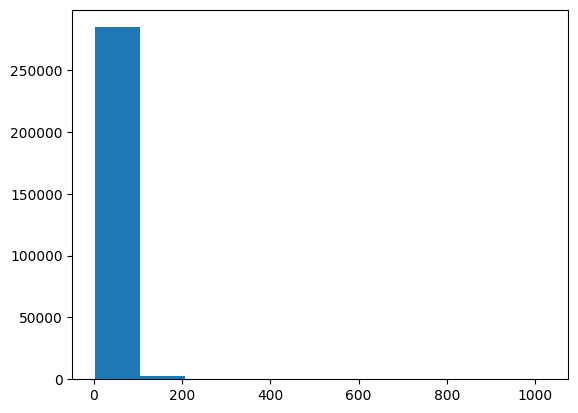

In [9]:
plt.hist([len(i['input_ids']) for i in tokenize_seq])

In [144]:
X = tf.keras.preprocessing.sequence.pad_sequences([i['input_ids'] for i in tokenize_seq], maxlen=128, truncating='post', padding='post', value=tokenizer.pad_token_id)
lable_to_id = { j: i for i, j in enumerate(np.sort(np.unique(data['star'])))}
y = [lable_to_id[i] + 1 for i in data['star']]
text_dataset = tf.data.Dataset.from_tensor_slices(X).batch(64)

In [11]:
features = []

for data in tqdm.tqdm(text_dataset):
    features.extend(tf.math.reduce_mean(backbone(data).last_hidden_state, axis=1))

features = np.array(features)

  0%|          | 0/4502 [00:00<?, ?it/s]

# Prepare train/test data

Split your data (extracted features and labels) into train and test subsets.

In [145]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features, y)

In [146]:
y_train = np.array(y_train).astype(float)
y_test = np.array(y_test).astype(float)

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [148]:
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
X_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train)
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test)

In [149]:
train_dataset = tf.data.Dataset.zip((X_train_dataset, y_train_dataset)).batch(256)
test_dataset = tf.data.Dataset.zip((X_test_dataset, y_test_dataset)).batch(256)

# Build the model

Build a simple model. The model should accept an extracted feature vector and return a vector of class logits (or probabilities). Model should only have a couple (or even 1) layer with weights.

In [191]:
inputs = tf.keras.layers.Input(768, name='input', dtype=tf.int32)
rate = tf.keras.layers.Dense(1, name='prediction', activation=tf.exp)(inputs)
p_y = tfp.layers.DistributionLambda(tfp.distributions.Poisson)(rate)
model = tf.keras.Model(inputs=inputs, outputs=p_y, name='MyModel')

def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)

Compile the model. Choose loss and metrics.

In [192]:
model.compile(loss=NLL, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=tf.keras.metrics.Poisson())

In [186]:
model.summary()

Model: "MyModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 prediction (Dense)          (None, 1)                 769       
                                                                 
 distribution_lambda_33 (Di  ((None, 1),               0         
 stributionLambda)            (None, 1))                         
                                                                 
Total params: 769 (3.00 KB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                             

# Train the model

In [194]:
hist_p = model.fit(train_dataset, validation_data=test_dataset, epochs=5)

Epoch 1/5
844/844 [==============================] - 21s 24ms/step - loss: 1.8536 - poisson: 0.3793 - val_loss: 1.8428 - val_poisson: 0.2348
Epoch 2/5
844/844 [==============================] - 20s 24ms/step - loss: 1.8532 - poisson: 0.3996 - val_loss: 1.8426 - val_poisson: 0.2081
Epoch 3/5
844/844 [==============================] - 21s 24ms/step - loss: 1.8530 - poisson: 0.3817 - val_loss: 1.8424 - val_poisson: 0.2196
Epoch 4/5
844/844 [==============================] - 21s 25ms/step - loss: 1.8528 - poisson: 0.3944 - val_loss: 1.8422 - val_poisson: 0.2240
Epoch 5/5
844/844 [==============================] - 20s 24ms/step - loss: 1.8527 - poisson: 0.3775 - val_loss: 1.8422 - val_poisson: 0.2250


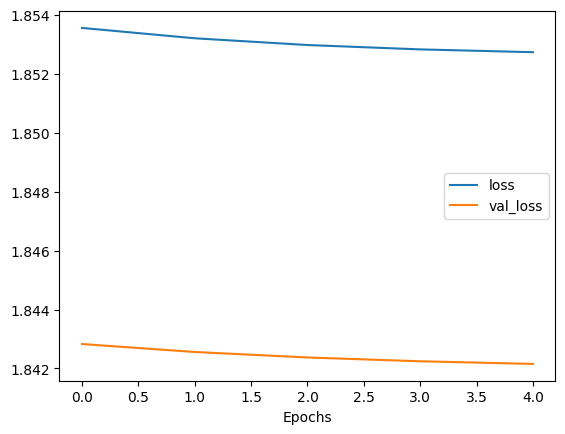

In [201]:
plt.plot(hist_p.history['loss'])
plt.plot(hist_p.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.show()

# Evaluation

Evalute the model on test data.

In [276]:
model.evaluate(test_dataset)

282/282 [==============================] - 5s 19ms/step - loss: 1.8422 - poisson: 0.2110


[1.842154622077942, 0.21096095442771912]

In [195]:
np.where(model.predict(X_test) <=5)[0]

2251/2251 [==============================] - 31s 14ms/step


array([    0,     1,     2, ..., 72014, 72015, 72016])

Plot confusion matrix.

2251/2251 [==============================] - 32s 14ms/step


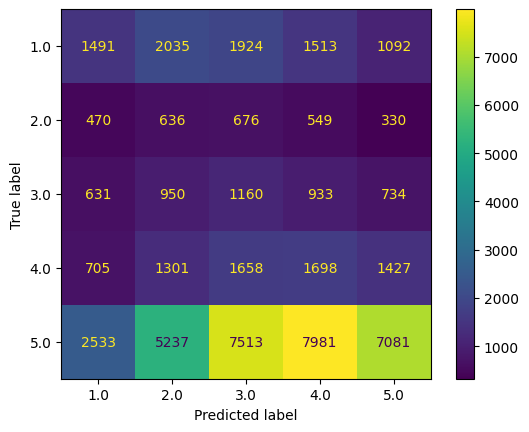

In [200]:
pred = model.predict(X_test)
pred_idx = np.where((pred > 0) & (pred <= 5))[0]

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test[pred_idx], pred[pred_idx])

Write a function to classify a piece of text.

In [204]:
def classify_text(text: str) -> int:
    x = tf.keras.preprocessing.sequence.pad_sequences([tokenizer(text)['input_ids']], maxlen=128, truncating='post', padding='post', value=tokenizer.pad_token_id)
    feature = tf.math.reduce_mean(backbone(x).last_hidden_state, axis=1)

    pred = model.predict(feature)
    
    return int(pred[0][0])

Evaluate the model on text not present in training and test data (come up with the text yourself). Try to get an input for each class.

In [282]:
classify_text('very bad app. plz delet this')

1/1 [==============================] - 0s 15ms/step


2

# Bonus

Write a function that computes word impact on text label. 

In [237]:
def get_words_impact(text: str) -> list[tuple[str, int]]:
    res = []
    
    for word in text.split():
        res.append((word, classify_text(word)))

    return res

Try to find out words that make text have a specific label.

In [289]:
get_words_impact('very bad app. plz delet this')

1/1 [==============================] - 0s 18ms/step


[('very', 3), ('bad', 1), ('app.', 4), ('plz', 2), ('delet', 1), ('this', 4)]